<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/280b_custom_object_segmentation_using_stardist_PREDICT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/3yk9sBja7YI

Segmenting images using custom-trained StarDist model.

Stardist takes care of cropping images and putting them back together so you do not have to worry about it. Just focus on reading large images and segmenting them. 

In [ ]:
!pip install stardist

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tifffile import imread
from tqdm import tqdm
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist.plot import render_label

In [ ]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
#Read images to be segmented.
X = sorted(glob('/content/drive/MyDrive/Colab Notebooks/data/mito_dataset_256x256/mito_images/*.tif'))
X = list(map(imread,X))

In [ ]:
#Verify the size of our images
X[0].shape

(256, 256)

**Segmenting 256x256 images**

Our StarDist model was trained on 256x256 input images. But it should not matter, we can segment any size image. Let us start with 256x256 and then expand to large images. 

In [ ]:
#Define the number of channels and normalize images with independendt channels or jointly
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]   
    


100%|██████████| 160/160 [00:00<00:00, 630.11it/s]


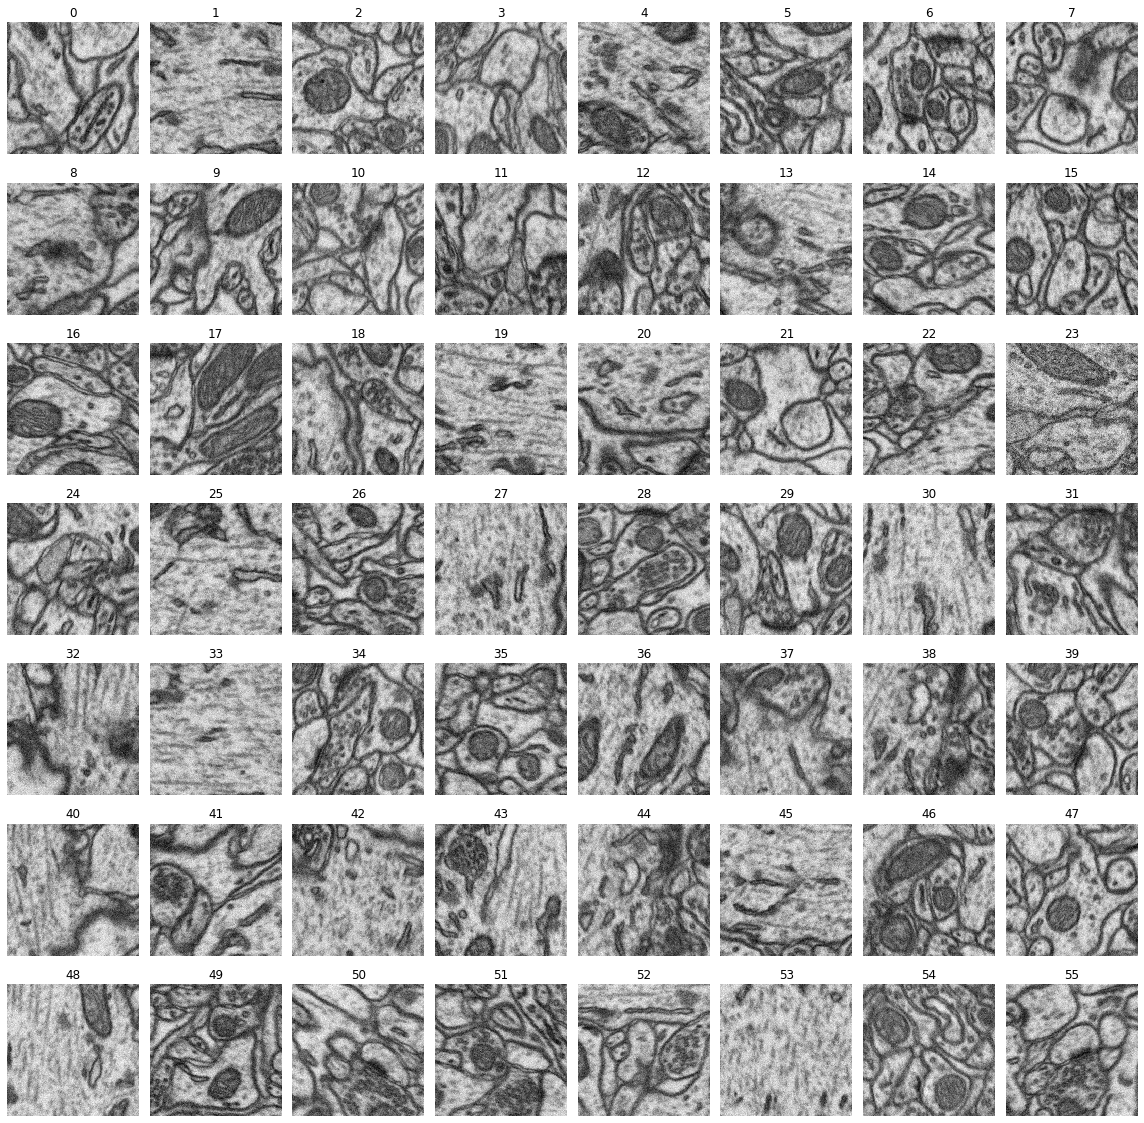

In [ ]:
fig, ax = plt.subplots(7,8, figsize=(16,16))
for i,(a,x) in enumerate(zip(ax.flat, X)):
  a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
  a.set_title(i)
  [a.axis('off') for a in ax.flat]
  plt.tight_layout()

In [ ]:
model = StarDist2D(None, name='stardist', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.562851, nms_thresh=0.3.


In [ ]:
from random import randint

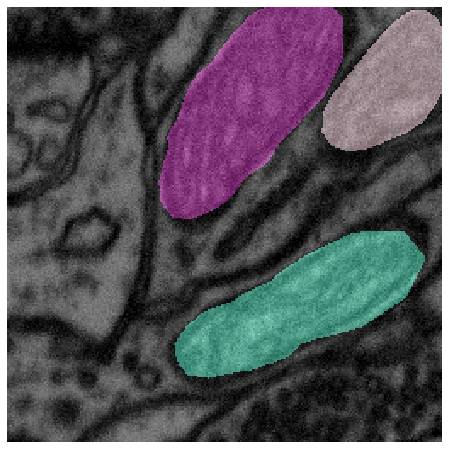

In [ ]:

img_num = randint(0, len(X)-1)
img = X[img_num]
#img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)


plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');


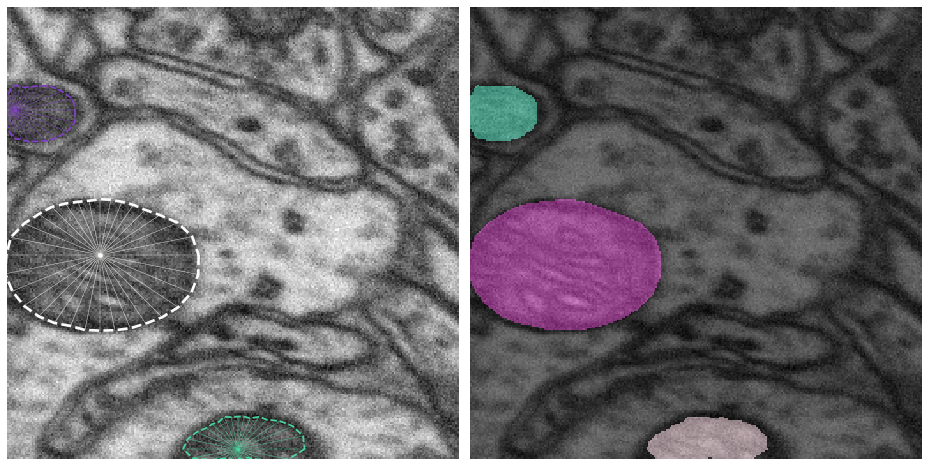

In [ ]:
#Plot 

def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
example(model, 16)

**Segmenting large images**

StarDist takes care of dividing images into required patches for segmentation. 

In [ ]:
my_img = imread("/content/drive/MyDrive/Colab Notebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")

In [ ]:
my_img.shape

(12, 768, 1024)

In [ ]:
my_img_norm = normalize(my_img[5], 1,99.8, axis=axis_norm)

In [ ]:
# model.predict_instances(..., n_tiles = (2,4,4)) crop the input images in the respective number of tiles (also takes care of voerlap)
segmented_img, details_img = model.predict_instances(my_img_norm, verbose=True)

predicting instances with nms_thresh = 0.3
non-maximum suppression...
keeping 11/1410 polyhedra
NMS took 0.0187 s


Text(0.5, 1.0, 'prediction')

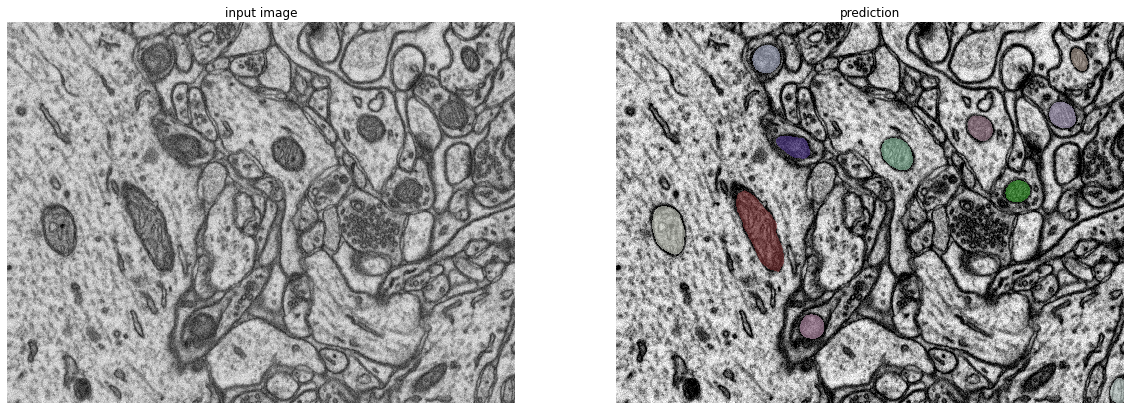

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(my_img_norm, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(segmented_img, img=my_img_norm))
plt.axis("off")
plt.title("prediction")